In [1]:
import os
# running from Root directory
os.chdir("..")

In [2]:
from connectome import Connectome
from connectome_types import SynapseDirection, cell_types, ClfType, m_types
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import networkx as nx
from collections import Counter
clf_type_space = [e.value for e in ClfType]

## Neuron Distributions

In [3]:
Conn = Connectome()
connectome = Conn.connectome
neurons = connectome.values()

In [4]:
neuron_cell_types = [n.cell_type for n in neurons]
neuron_m_types = [n.mtype for n in neurons]
neuron_clf_types = [n.clf_type.value for n in neurons]

In [5]:
def plot_neuron_type_dist(neuron_cell_types, labels, subtitle):
    unique, counts = np.unique(neuron_cell_types, return_counts=True)
    type_counts = dict(zip(unique, counts))
    sorted_labels = sorted(labels)
    
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(sorted_labels)), [type_counts.get(label, 0) for label in sorted_labels])
    plt.xticks(range(len(sorted_labels)), sorted_labels, rotation=45)
    plt.xlabel('Neuron Types')
    plt.ylabel('Count')
    plt.title(f'Distribution of Neuron Types ({subtitle})')
    plt.tight_layout()
    plt.show()

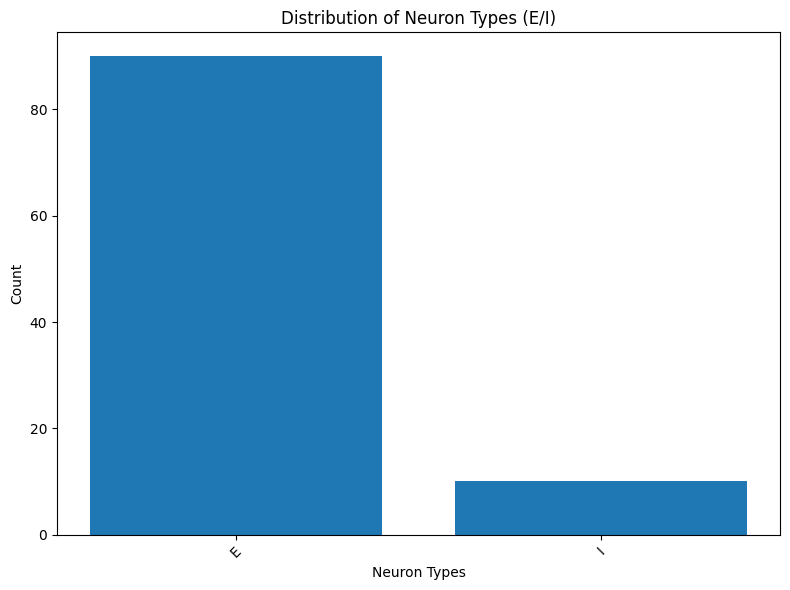

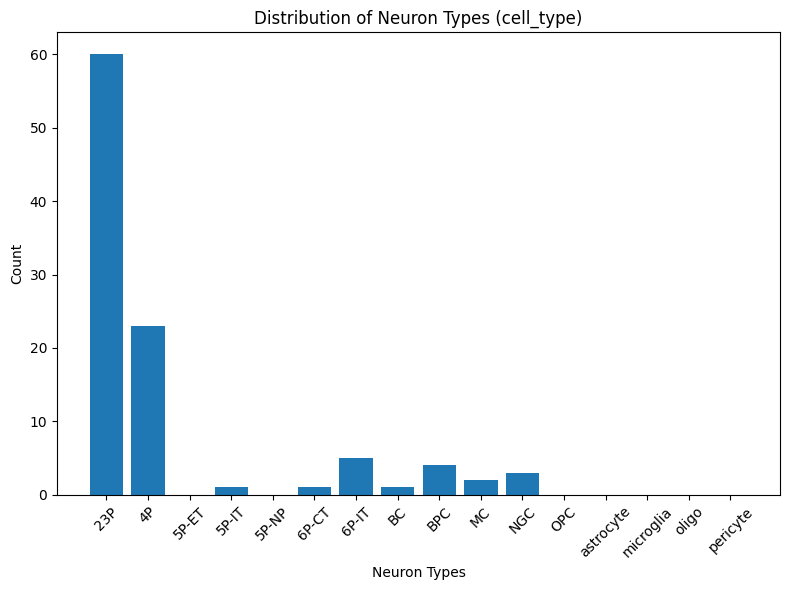

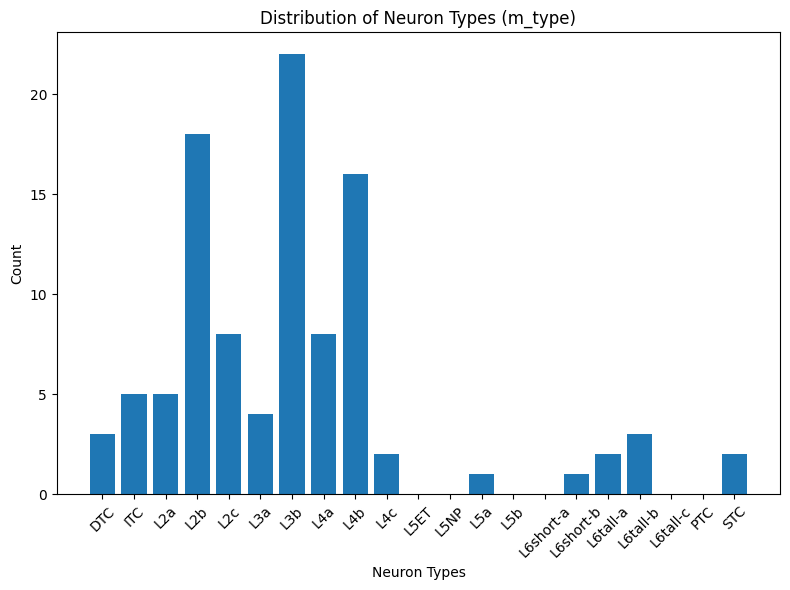

In [6]:
plot_neuron_type_dist(neuron_clf_types, clf_type_space, 'E/I')
plot_neuron_type_dist(neuron_cell_types, cell_types, 'cell_type')
plot_neuron_type_dist(neuron_m_types, m_types, 'm_type')

## Connectivity Matrix

In [7]:
def plot_cell_type_conn_matrix(z, labels, title, text_inside=False):
    c = plt.imshow(z, cmap ='YlOrRd') 
    plt.colorbar(c) 
    plt.title(f'{title}', fontweight ="bold") 
    
    plt.xticks(ticks=np.arange(len(labels)), labels=labels,  rotation=90)
    plt.yticks(ticks=np.arange(len(labels)), labels=labels)
    plt.ylabel('Postsynaptic neuron type'); plt.xlabel('Presynaptic neuron type');

    if text_inside:
        for i in range(z.shape[0]):
            for j in range(z.shape[1]):
                plt.text(j, i, f'{z[i, j]:.2f}', ha='center', va='center', color='black')
        
    plt.show() 

In [8]:
mtype_mat = Conn.calculate_cell_type_conn_matrix('mtype', m_types)
celltype_mat = Conn.calculate_cell_type_conn_matrix('cell_type', cell_types)
clftype_mat = Conn.calculate_cell_type_conn_matrix('clf_type', clf_type_space)

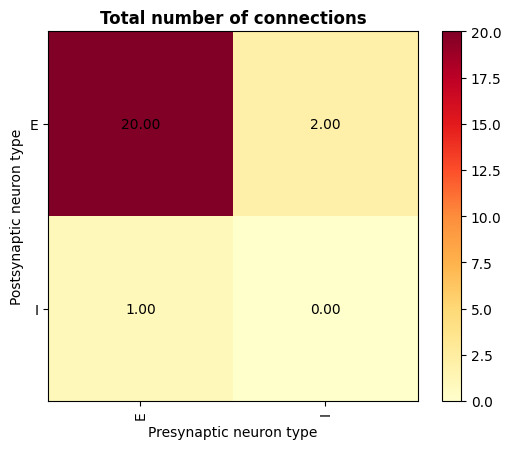

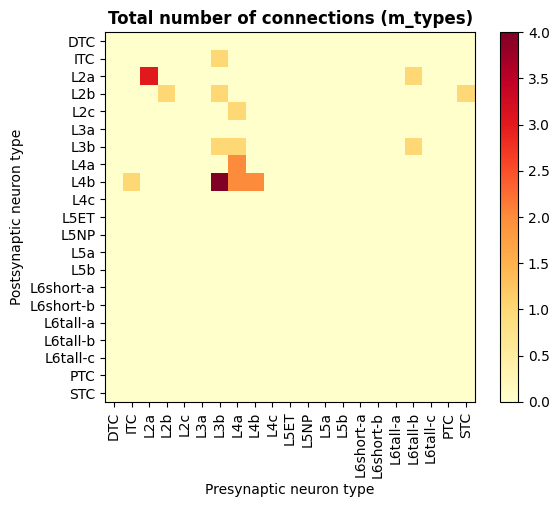

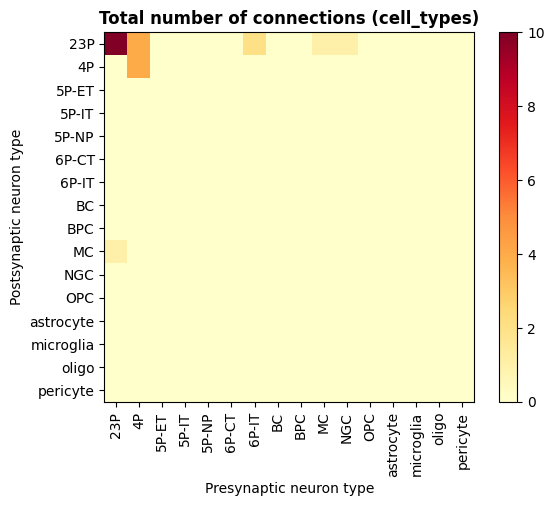

In [9]:
plot_cell_type_conn_matrix(clftype_mat, clf_type_space, 'Total number of connections', True)
plot_cell_type_conn_matrix(mtype_mat, m_types, 'Total number of connections (m_types)')
plot_cell_type_conn_matrix(celltype_mat, cell_types, 'Total number of connections (cell_types)')

In [10]:
def plot_boxplot(data_dict, labels, title):
    df = pd.DataFrame(data_dict)
    df_melted = df.melt(var_name='Type', value_name='Number of connections')
    sums = df_melted.groupby('Type')['Number of connections'].sum()
    
    plt.figure()
    plt.title(title)
    ax = sns.boxplot(y='Type', x='Number of connections', data=df_melted)

    ytick_labels = [f'{label} (N={sums.iloc[i]:.0f})' for (i, label) in enumerate(labels)]
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(ytick_labels)
    
    plt.tight_layout()

def plot_cell_type_distribution(matrix, labels):   
    outgoing_dict = {label: row.tolist() for label, row in zip(labels, matrix)}
    ingoing_dict = {label: matrix[:, i].tolist() for i, label in enumerate(labels)}

    plot_boxplot(outgoing_dict, labels, 'Outgoing connections')
    plot_boxplot(ingoing_dict, labels, 'Incoming connections')

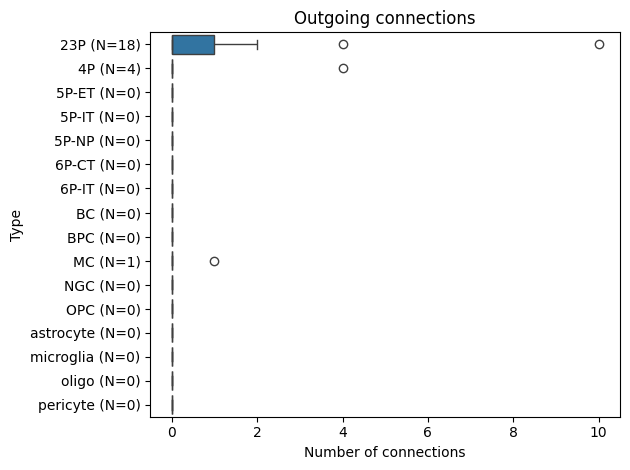

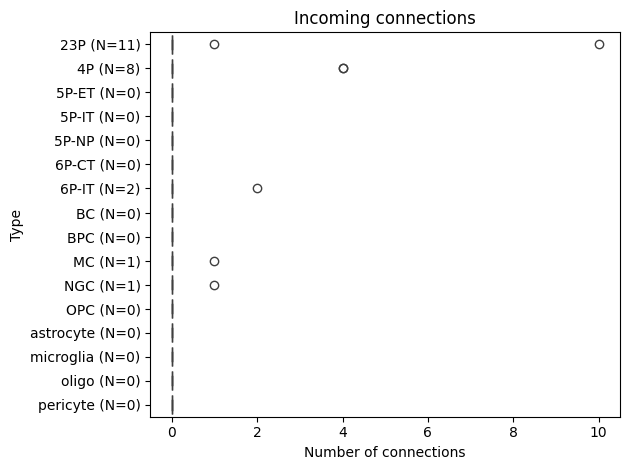

In [11]:
plot_cell_type_distribution(celltype_mat, cell_types)

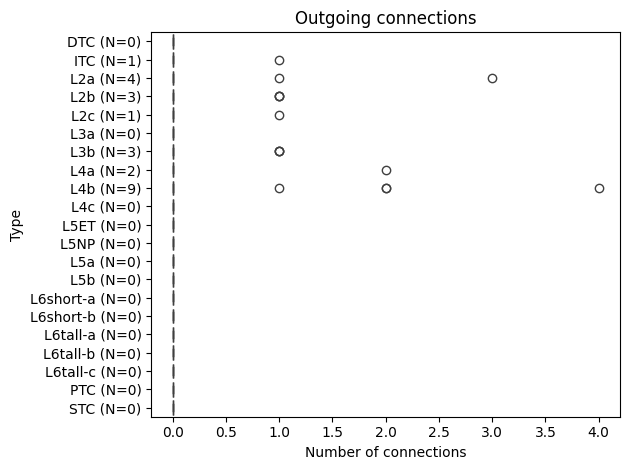

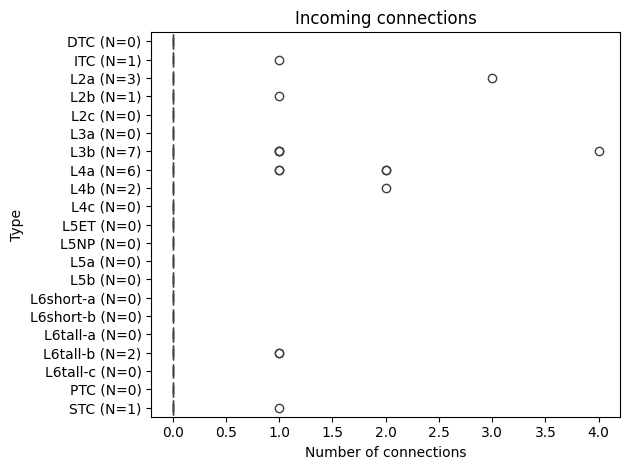

In [12]:
plot_cell_type_distribution(mtype_mat, m_types)

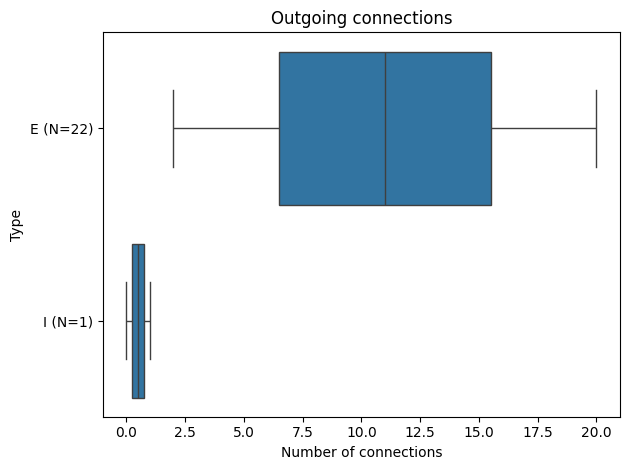

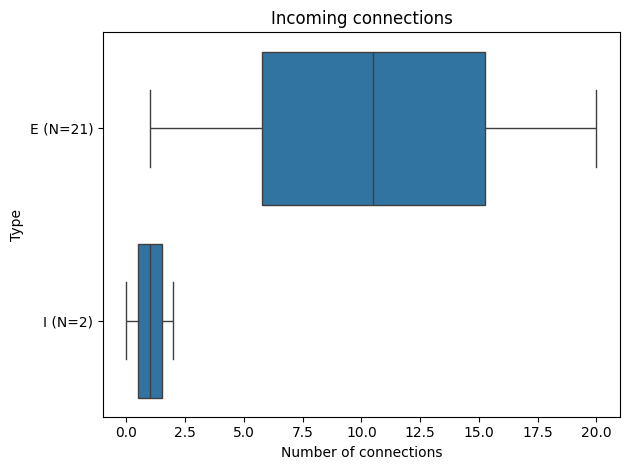

In [13]:
plot_cell_type_distribution(clftype_mat, clf_type_space)

## Synapse Attributes

In [14]:
celltype_input_syn_sizes = Conn.calculate_cell_type_synapse_attr('cell_type', cell_types, SynapseDirection.input, 'size')
celltype_output_syn_sizes = Conn.calculate_cell_type_synapse_attr('cell_type', cell_types, SynapseDirection.output, 'size')
celltype_syn_dist_to_soma = Conn.calculate_cell_type_synapse_dist_to_soma('cell_type', cell_types)

In [15]:
def plot_cell_type_syn_attr(keys_subset, syn_data, title, legend_title, x_label, micro_scale=False):
    for key in syn_data:
        if key not in keys_subset:
            continue
        if syn_data[key]:
            values = [t[1] for t in syn_data[key]]
            if micro_scale:
                values = [v / 1000 for v in values]
            plt.hist(values, bins=10, alpha=0.5, label=key)
    
    plt.ylabel('Frequency'); plt.xlabel(x_label); plt.title(title); plt.legend(title=legend_title); plt.show()

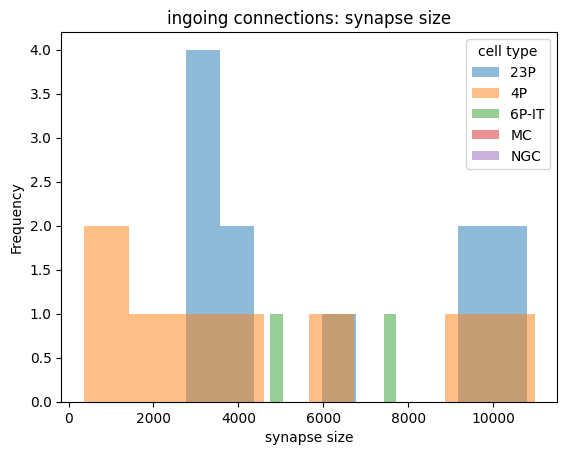

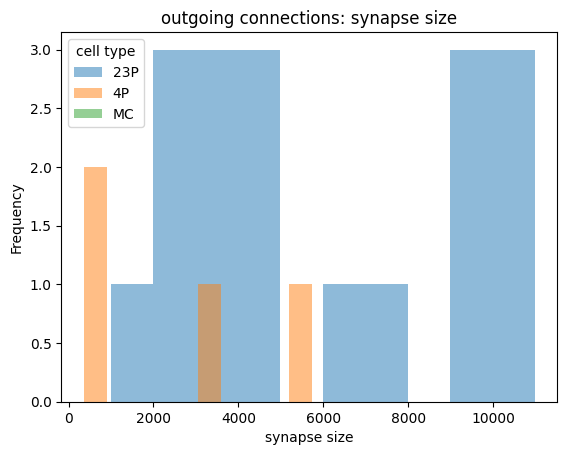

In [16]:
keys_subset = ['23P']
plot_cell_type_syn_attr(keys_subset=cell_types,
                        syn_data=celltype_input_syn_sizes,
                        title='ingoing connections: synapse size',
                        legend_title='cell type',
                        x_label='synapse size'
                       )
plot_cell_type_syn_attr(keys_subset=cell_types,
                        syn_data=celltype_output_syn_sizes,
                        title='outgoing connections: synapse size',
                        legend_title='cell type',
                        x_label='synapse size'
                       )

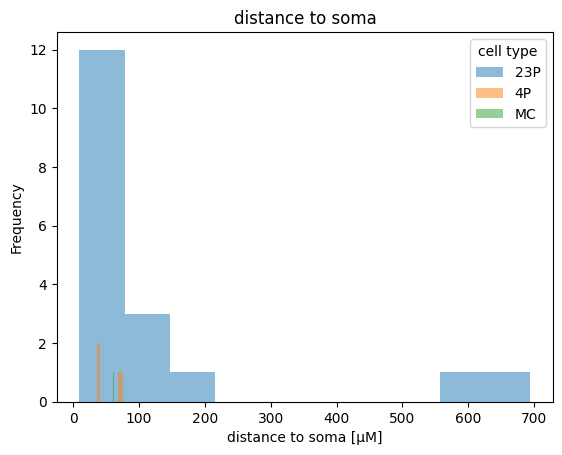

In [17]:
plot_cell_type_syn_attr(keys_subset=cell_types,
                        syn_data=celltype_syn_dist_to_soma,
                        title='distance to soma',
                        legend_title='cell type',
                        x_label='distance to soma [μM]',
                        micro_scale=True)